# Child Labour Prediction 

The aim of this analysis is to predict households with child labour in Argentina for 2022. I use an XGBoost and a Neural Network model to make a binary classification. Since the EANNA 2016/17 is the latest survey that captures child labour, the prediction is done on the EPH 2021 (Argentina Permanent Household Survey) which is also a household questionnaire and it is conducted more frequently (every four months each year). A limitation of this approach is that I’m forced to select the variables which are the same in both surveys. Luckily, both of them are similar as far as the methodology in which they record each sample.

The training dataset is based on the EANNA 2016/17 Dataset which is made up of 3 surveys. The first survey (C1) is a household survey, it describes the general characteristics of the sample population, including composition by age and sex, residence, household size, education, housing facilities, etc. Each record of C1 represents a household, which is identified with an ID variable (“CODIGO”). The other two questionnaires from the EANNA 2016/17 survey (C2 and C3), describe the characteristics of the individuals living at each house. Each record is also identified with the household ID (“CODIGO”) which links them to a household. This allows me to group by household ID in order to create a single dataframe to use as a training set.

The test set is based on the EPH 2021 which is made up of 2 surveys: 

EPHOG (household characteristics), which is similar to C1.
EPIND: (individuals living at each household) similar to C2 and C3.

Same as EANNA 2016/17, both EPHOG and EPIND use an ID (“CODUSU”).

The goal is to predict how many households in EPH 2021 have child labour and to analyze which are the relevant variables in this experiment. 
 
***I haven’t finished it yet. I’m trying to improve the performance of the neural network model.


# Selected variables:



Number of rooms: C1_P04

Mother or father in charge: C1_P13

Water acces: C1_P06

Has a Bathroom?: C1_P09

Type of Sewer: C1_P11

Subsidies from the Goverment: Hog_AUH

Region: NREGION

Type of household: C1_P01

Housing material: C1_P03

Gas access DefGas:

Number of children in the house: CantPob_0_17

Number of individuals living in the house: TamHog

Age: C2_P02

Sex: C2_P03

Marital status: C2_P07

Employed?: ESTADO

Type of job: CATOCUP

Private/Public school: C3_E07

In [2]:
import  pandas  as pd
import  matplotlib.pyplot as plt
import numpy as np
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm     
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from tensorflow import keras

In [3]:
#Import each dataset

EPHOG = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\usu_hogar_T321.csv', sep=';')
EPIND = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\usu_individual_T321.csv', sep=';')
C1 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C1_ EANNA_URBANA_Completa_02.csv', sep=';')
C2 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C2_ EANNA URBANA_Completa_07.csv', sep=';')
C3 = pd.read_csv(r'C:\Users\marti\OneDrive\Escritorio\UDESA\TESIS\Base de datos\C3_EANNA_URBANA_Completa_04.csv', sep=';')

C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#Select the variables from EPH which are the same in EANNA

eph_h = EPHOG[['CODUSU','IV2','II7', 'IV6' ,'IV8', 'IV11', 'V5', 'REGION', 'IV1', 'IV3', 'II8', 'IX_MEN10', 'IX_TOT']]
eph_i = EPIND[['CODUSU', 'CH03','CH06', 'CH04', 'CH07', 'ESTADO','CH11']]

In [5]:
#Rename columns so to match them with EANNA

eph_h.columns = ['CODIGO','C1_P04', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH', 'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'CantPob_0_17', 'TamHog']
eph_i.columns = ['CODIGO', 'C2_P04', 'C2_P02', 'C2_P03', 'C2_P07', 'ESTADO', 'C3_E07']

In [6]:
#Select the variables from EANNA and replace empty values with NaN

eanna_h = C1[['CODIGO','C1_P04', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH', 'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'CantPob_0_17']]
eanna_h = eanna_h.replace(r'^\s*$', np.nan, regex=True)

eanna_i = C2[['CODIGO', 'C2_P04', 'C2_P02', 'C2_P03', 'C2_P07', 'ESTADO', 'TamHog']]
eanna_i = eanna_i.replace(r'^\s*$', np.nan, regex=True)

eanna_c = C3[['CODIGO','C3_E07', 'Trabaja']]
eanna_c = eanna_c.replace(r'^\s*$', np.nan, regex=True)

In [7]:
#Check if there is any missing value.

from funciones import missing_values

missing_values_eanna_h = missing_values(eanna_h)
missing_values_eanna_h


Your selected dataframe has 12 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Hog_AUH,14363,55.0
C1_P11,257,1.0
C1_P04,20,0.1
C1_P03,20,0.1


In [8]:
missing_values_eanna_c = missing_values(eanna_c)
missing_values_eanna_c


Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
C3_E07,1102,6.6


In [9]:
missing_values_eanna_c = missing_values(eanna_i)
missing_values_eanna_c


Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [10]:
#Replace missing values with mode. Convert columns to numeric type.

col = ["C3_E07"]
eanna_c[col]=eanna_c[col].fillna(eanna_c.mode().iloc[0])



cols = ["Hog_AUH", "C1_P11", "C1_P04", "C1_P03"]
eanna_h[cols]=eanna_h[cols].fillna(eanna_h.mode().iloc[0])



eanna_c = eanna_c.apply(pd.to_numeric)
eanna_h = eanna_h.apply(pd.to_numeric)
eanna_i = eanna_i.apply(pd.to_numeric)


In [11]:
#Correct variables in EANNA that measure the same but with different values


eanna_h.loc[eanna_h["C1_P13"] > 4, "C1_P13"] = 6

eanna_h.loc[eanna_h["C1_P06"] > 3, "C1_P06"] = 3

eanna_h.loc[eanna_h["C1_P09"] > 3, "C1_P09"] = 2

eanna_h.loc[eanna_h["C1_P11"] > 4, "C1_P11"] = 4

eanna_h.loc[eanna_h["C1_P01"] == 5, "C1_P01"] = 4


eanna_h1 = eanna_h.copy()

eanna_h1.loc[eanna_h["C1_P01"] > 5, "C1_P01"] = 5

eanna_h1.loc[eanna_h["C1_P03"] > 3, "C1_P03"] = 3

eanna_h1.loc[eanna_h["DefGas"] == 99, "DefGas"] = 3


eanna_i.loc[eanna_i["C2_P04"] == 99, "C2_P04"] = 10

eanna_i.loc[eanna_i["C2_P07"] == 4, "C2_P07"] = 3

eanna_i1 = eanna_i.copy()

eanna_i.loc[eanna_i["C2_P07"] == 5, "C2_P07"] = 4

eanna_i2 = eanna_i1.copy()

eanna_i2.loc[eanna_i["C2_P07"] == 6, "C2_P07"] = 5

eanna_i3 = eanna_i2.copy()

eanna_i3.loc[eanna_i["C2_P07"] ==9, "C2_P07"] = 5

eanna_i3.loc[eanna_i["ESTADO"] ==9, "ESTADO"] = 3

eanna_i3.loc[eanna_i["ESTADO"] ==97, "ESTADO"] = 4

eanna_i3.loc[eanna_i["ESTADO"] ==98, "ESTADO"] = 3

In [12]:
#Same for EPH

eph_h2 = eph_h.copy()

eph_h2.loc[eph_h2["TamHog"] > 8, "TamHog"] = 7

In [13]:
#Group by household ID  for EPH using median. 

eph_i_h = eph_i.groupby("CODIGO", as_index=False).median().round()

#Same for EANNA.

eanna_i_h = eanna_i3.groupby("CODIGO", as_index=False).median().round()
eanna_c_h = eanna_c.groupby("CODIGO", as_index=False).median().round()


In [14]:
#Check the shape of each df

shapes = {'eph_h': eph_h.shape, 'eph_i_h': eph_i_h.shape, 'eanna_h': eanna_h.shape, 'eanna_c_h': eanna_c_h.shape, 'eanna_i_h': eanna_i_h.shape}
print(shapes)

{'eph_h': (16285, 13), 'eph_i_h': (16150, 7), 'eanna_h': (26115, 12), 'eanna_c_h': (9922, 3), 'eanna_i_h': (26115, 7)}


In [15]:
#Merge household and indvidual dataframe on household ID

from functools import reduce

eph_df = pd.merge(eph_h2, eph_i_h, how='outer', on ='CODIGO')

dfs_eanna = [eanna_h1, eanna_i_h, eanna_c_h]

eanna_df = reduce(lambda left,right: pd.merge(left,right,on='CODIGO'), dfs_eanna)

print("eanna df shape: ", eanna_df.shape, "eph shape: ", eph_df.shape)

eanna df shape:  (9922, 20) eph shape:  (16285, 19)


In [16]:
#Reorder colums so that eanna_df and eph_df match

eanna_df = eanna_df.apply(pd.to_numeric)

eph_df = eph_df[['CODIGO', 'C1_P04', 'C1_P13', 'C1_P06', 'C1_P09', 'C1_P11', 'Hog_AUH',
       'NREGION', 'C1_P01', 'C1_P03', 'DefGas', 'CantPob_0_17', 'C2_P04',
       'C2_P02', 'C2_P03', 'C2_P07', 'ESTADO', 'TamHog', 'C3_E07']]

In [23]:
#Drop ID and the output variable from X. 

X = eanna_df.drop(['Trabaja', 'CODIGO'], axis=1)
y = eanna_df['Trabaja']

eph_pred = eph_df.drop(['CODIGO'], axis=1)


In [84]:
#Check if the eanna_df (training dataset) is balanced

t = eanna_df['Trabaja'].sum()

print("Percentage of households with child labour: ", t/len(y)*100)


Percentage of households with child labour:  3.5398230088495577


In [38]:
#Since the dataset is not balanced, I use SMOTE to solve this.

from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling import SMOTE


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# XGBOOST

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import cv
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)



In [40]:
# import libraries
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# get the categorical and numeric column names
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# pipeline for numerical columns
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
# pipeline for categorical columns
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N/A'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


In [41]:
#XGBoost uses an internal data structure DMatrix which optimizes both memory effieciency and speed



dm_train = xgb.DMatrix(X_train, label=y_train)
dm_test = xgb.DMatrix(X_test, label=y_test)

In [42]:
#Building Model

#Ideal case would include an exhaustive gridsearch on all the parameters but its computationally intensive.
#So I'll focus on few important parameters and tune them sequentially using logistic loss function.


# max_depth
# min_child_weight
# subsample
# colsample_bytree
# eta
# num_boost_rounds
# early_stopping_rounds




params = {'max_depth':6, 'min_child_weight':1, 'eta':0.3, 'subsample':1, 
          'colsample_bytree':1, 'objective':'binary:logistic',}


In [43]:
#Cross validation is used to tune the parameters within the params dictionary.

gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(1,4)
                    for min_child_weight in range(17,21)]

In [44]:
logloss_min = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 100,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("max_depth: {} | min_child_weight: {} with Logloss: {:.3}\n".format(max_depth,min_child_weight,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (max_depth, min_child_weight)

        
print("Best Parameters: max_depth: {} | min_child_weight: {} with Logloss: {:.3f}". format(best_params[0], 
                                                                                  best_params[1], logloss_min))

max_depth: 1 | min_child_weight: 17 with Logloss: 0.416

max_depth: 1 | min_child_weight: 18 with Logloss: 0.416

max_depth: 1 | min_child_weight: 19 with Logloss: 0.416

max_depth: 1 | min_child_weight: 20 with Logloss: 0.416

max_depth: 2 | min_child_weight: 17 with Logloss: 0.237

max_depth: 2 | min_child_weight: 18 with Logloss: 0.238

max_depth: 2 | min_child_weight: 19 with Logloss: 0.238

max_depth: 2 | min_child_weight: 20 with Logloss: 0.239

max_depth: 3 | min_child_weight: 17 with Logloss: 0.207

max_depth: 3 | min_child_weight: 18 with Logloss: 0.207

max_depth: 3 | min_child_weight: 19 with Logloss: 0.208

max_depth: 3 | min_child_weight: 20 with Logloss: 0.209

Best Parameters: max_depth: 3 | min_child_weight: 18 with Logloss: 0.207


In [51]:
# Updating the parameters

params['max_depth'] = 3
params['min_child_weight'] = 18

In [46]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(1,5)]]

In [47]:
logloss_min = float("Inf")
best_params = None

for subsample, colsample in (gridsearch_params):
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 100,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("subsample: {} | colsample: {} with Logloss: {:.3f}\n".format(subsample,colsample,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (subsample, colsample)
        
print("Best Parameters: subsample: {} | colsample: {} with Logloss: {:.3f}". format(best_params[0], 
                                                                           best_params[1], logloss_min))

subsample: 0.7 | colsample: 0.1 with Logloss: 0.311

subsample: 0.7 | colsample: 0.2 with Logloss: 0.257

subsample: 0.7 | colsample: 0.3 with Logloss: 0.249

subsample: 0.7 | colsample: 0.4 with Logloss: 0.248

subsample: 0.8 | colsample: 0.1 with Logloss: 0.310

subsample: 0.8 | colsample: 0.2 with Logloss: 0.256

subsample: 0.8 | colsample: 0.3 with Logloss: 0.247

subsample: 0.8 | colsample: 0.4 with Logloss: 0.246

subsample: 0.9 | colsample: 0.1 with Logloss: 0.310

subsample: 0.9 | colsample: 0.2 with Logloss: 0.255

subsample: 0.9 | colsample: 0.3 with Logloss: 0.246

subsample: 0.9 | colsample: 0.4 with Logloss: 0.244

subsample: 1.0 | colsample: 0.1 with Logloss: 0.305

subsample: 1.0 | colsample: 0.2 with Logloss: 0.254

subsample: 1.0 | colsample: 0.3 with Logloss: 0.244

subsample: 1.0 | colsample: 0.4 with Logloss: 0.241

Best Parameters: subsample: 1.0 | colsample: 0.4 with Logloss: 0.241


In [50]:
params['subsample'] = 1.0
params['colsample_bytree'] = 0.4

In [49]:


logloss_min = float("Inf")
best_params = None

for eta in [0.3, 0.2, 0.1, 0.05, 0.01, 0.005]:
    
    params['eta'] = eta
    
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 100,
                      seed = 0, nfold=10, metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    print("eta: {} with Logloss: {:.3}\n".format(eta,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = eta
        
print("Best Parameter: eta: {} with Logloss: {:.3f}". format(best_params, logloss_min))

eta: 0.3 with Logloss: 0.244

eta: 0.2 with Logloss: 0.277

eta: 0.1 with Logloss: 0.361

eta: 0.05 with Logloss: 0.433

eta: 0.01 with Logloss: 0.583

eta: 0.005 with Logloss: 0.629

Best Parameter: eta: 0.3 with Logloss: 0.244


In [52]:
params['eta'] = 0.3

In [53]:
params

{'max_depth': 3,
 'min_child_weight': 18,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 0.4,
 'objective': 'binary:logistic'}

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Init classifier
xgb_cl = xgb.XGBClassifier(**params)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Score

accuracies = cross_val_score(estimator = xgb_cl, X = X_train, y = y_train, cv = cv)

xgb_cl.fit(X_train, y_train)

preds = xgb_cl.predict(X_test)

print(accuracies.mean())
print(accuracies.std())
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))



0.9269200505769905
0.008028526426175405
[[2704   37]
 [ 435 2384]]
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      2741
         1.0       0.98      0.85      0.91      2819

    accuracy                           0.92      5560
   macro avg       0.92      0.92      0.91      5560
weighted avg       0.92      0.92      0.91      5560



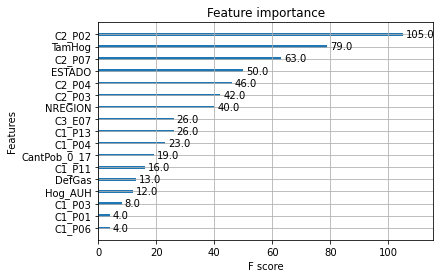

<Figure size 1152x864 with 0 Axes>

In [55]:
#Importance of each variable

xgb.plot_importance(xgb_cl)
plt.figure(figsize = (16, 12))
fig1 = plt.gcf()
fig1.savefig(r'C:\Users\marti\OneDrive\Escritorio\fxgboost.png', dpi=100)

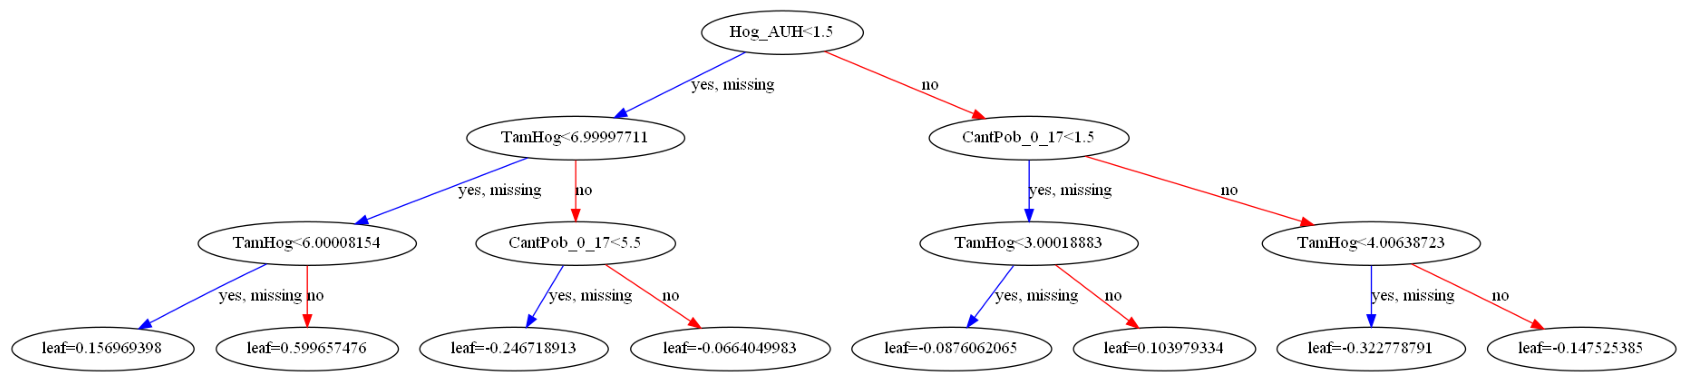

In [56]:
#Plotting the tree

from xgboost import plot_tree

plot_tree(xgb_cl, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30, 15)

In [58]:
#Prediction for EPH 2021 dataset


final_prediction = xgb_cl.predict(eph_pred)



eph_pred_final2 = pd.DataFrame(final_prediction, columns = ['Trabaja'])

t1 = eph_pred_final2['Trabaja'].sum()
p2 = t1/len(eph_pred_final2) 

print( "Percentage of households with child labour: ", p2*100)

Percentage of households with child labour:  4.562480810561867


It seems that age (C2_P02) and the number of individuals living at each house (TamHog) are the most relevant variables to explain child labour. Porcentage of households with child labour is 4,5% in 2021 vs 3.5% in 2016.

# NEURAL NETWORK

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping








# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in the validation loss for 10 consecutive epochs.  

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', 
                                   patience=10,
                                   restore_best_weights=True)


history = model.fit(X,
                    y,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                304       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
1483/1483 [==============================] - 2s 1ms/step - loss: 0.6637 - accuracy: 0.6196 - val_loss: 0.8204 - val_accuracy: 0.3671
Epoch 2/80
1483/1483 [==============================] - 2s 1ms/step - loss: 0.6249 - accuracy: 0.6510 - val_loss: 0.9023 - val_accuracy: 0.2201
Epoch 3/80
1483/1483 [==========

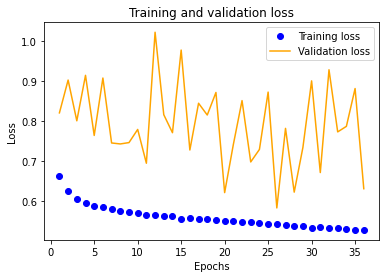

In [75]:
#Plotting the training and validation loss

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']


epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

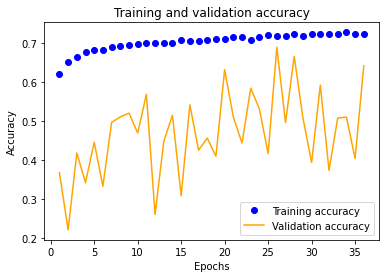

0.6881575584411621

In [76]:
#Plotting the training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')

plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)

In [77]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


model.predict(X) 
np.round(model.predict(X),0) 



preds = np.round(model.predict(X),0)


print(confusion_matrix(y, preds)) 

print(classification_report(y, preds))

[[6986 2280]
 [3022 6244]]
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72      9266
         1.0       0.73      0.67      0.70      9266

    accuracy                           0.71     18532
   macro avg       0.72      0.71      0.71     18532
weighted avg       0.72      0.71      0.71     18532

